<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap08/8_2_Bias_Variance_Trade_Off.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 8.2: Bias-Variance Trade-Off**

This notebook investigates the bias-variance trade-off for the toy model used throughout chapter 8 and reproduces the bias/variance trade off curves seen in figure 8.9.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# The true function that we are trying to estimate, defined on [0,1]
def true_function(x):
    y = np.exp(np.sin(x*(2*3.1413)))
    return y

In [3]:
# Generate some data points with or without noise
def generate_data(n_data, sigma_y=0.3):
    # Generate x values quasi uniformly
    x = np.ones(n_data)
    for i in range(n_data):
        x[i] = np.random.uniform(i/n_data, (i+1)/n_data, 1)

    # y value from running through function and adding noise
    y = np.ones(n_data)
    for i in range(n_data):
        y[i] = true_function(x[i])
        y[i] += np.random.normal(0, sigma_y, 1)
    return x,y


In [4]:
# Draw the fitted function, together with uncertainty used to generate points
def plot_function(x_func, y_func, x_data=None,y_data=None, x_model = None, y_model =None, sigma_func = None, sigma_model=None):

    fig,ax = plt.subplots()
    ax.plot(x_func, y_func, 'k-')
    if sigma_func is not None:
      ax.fill_between(x_func, y_func-2*sigma_func, y_func+2*sigma_func, color='lightgray')

    if x_data is not None:
        ax.plot(x_data, y_data, 'o', color='#d18362')

    if x_model is not None:
        ax.plot(x_model, y_model, '-', color='#7fe7de')

    if sigma_model is not None:
      ax.fill_between(x_model, y_model-2*sigma_model, y_model+2*sigma_model, color='lightgray')

    ax.set_xlim(0,1)
    ax.set_xlabel('Input, $x$')
    ax.set_ylabel('Output, $y$')
    plt.show()

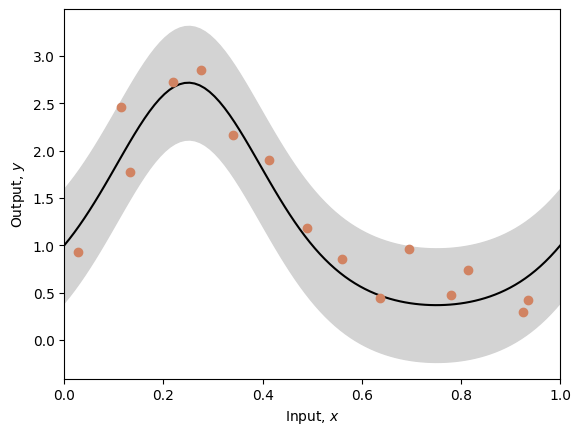

In [5]:
# Generate true function
x_func = np.linspace(0, 1.0, 100)
y_func = true_function(x_func);

# Generate some data points
np.random.seed(1)
sigma_func = 0.3
n_data = 15
x_data,y_data = generate_data(n_data, sigma_func)

# Plot the functinon, data and uncertainty
plot_function(x_func, y_func, x_data, y_data, sigma_func=sigma_func)

In [6]:
# Define model -- beta is a scalar and omega has size n_hidden,1
def network(x, beta, omega):
    # Retrieve number of hidden units
    n_hidden = omega.shape[0]

    y = np.zeros_like(x)
    for c_hidden in range(n_hidden):
        # Evaluate activations based on shifted lines (figure 8.4b-d)
        line_vals =  x  - c_hidden/n_hidden
        h =  line_vals * (line_vals > 0)
        # Weight activations by omega parameters and sum
        y = y + omega[c_hidden] * h
    # Add bias, beta
    y = y + beta

    return y

In [7]:
# This fits the n_hidden+1 parameters (see fig 8.4a) in closed form.
# If you have studied linear algebra, then you will know it is a least
# squares solution of the form (A^TA)^-1A^Tb.  If you don't recognize that,
# then just take it on trust that this gives you the best possible solution.
def fit_model_closed_form(x,y,n_hidden):
  n_data = len(x)
  A = np.ones((n_data, n_hidden+1))
  for i in range(n_data):
      for j in range(1,n_hidden+1):
          A[i,j] = x[i]-(j-1)/n_hidden
          if A[i,j] < 0:
              A[i,j] = 0;

  beta_omega = np.linalg.lstsq(A, y, rcond=None)[0]

  beta = beta_omega[0]
  omega = beta_omega[1:]

  return beta, omega


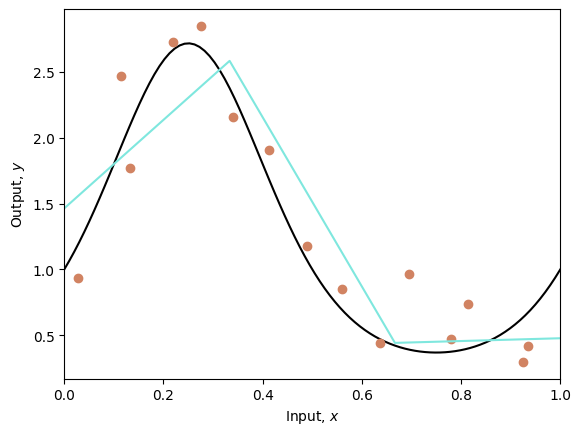

In [8]:
# Closed form solution
beta, omega = fit_model_closed_form(x_data,y_data,n_hidden=3)

# Get prediction for model across graph range
x_model = np.linspace(0,1,100);
y_model = network(x_model, beta, omega)

# Draw the function and the model
plot_function(x_func, y_func, x_data,y_data, x_model, y_model)

In [9]:
# Run the model many times with different datasets and return the mean and variance
def get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func):

  # Create array that stores model results in rows
  y_model_all = np.zeros((n_datasets, x_model.shape[0]))

  for c_dataset in range(n_datasets):
    x_data,y_data = generate_data(n_data, sigma_func)
    beta, omega = fit_model_closed_form(x_data, y_data, n_hidden)
    y_model = network(x_model, beta, omega)

    # Store the model results
    y_model_all[c_dataset,:] = y_model

  # Get mean and standard deviation of model
  mean_model = np.mean(y_model_all,axis=0)
  std_model = np.std(y_model_all,axis=0)

  # Return the mean and standard deviation of the fitted model
  return mean_model, std_model

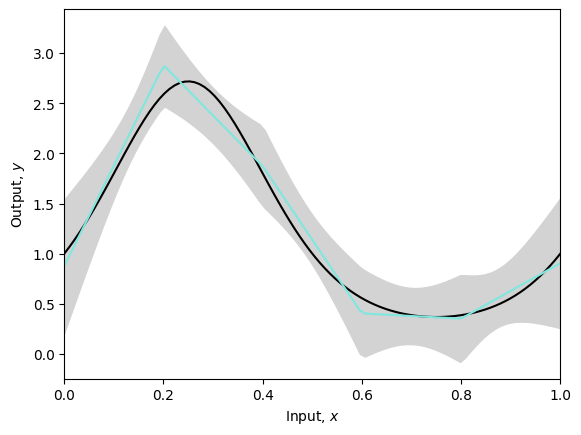

In [25]:
# Let's generate N random data sets, fit the model N times and look the mean and variance
n_datasets = 100
n_data = 15
sigma_func = 0.3
n_hidden = 5

# Get mean and variance of fitted model
np.random.seed(1)
mean_model, std_model = get_model_mean_variance(n_data, n_datasets, n_hidden, sigma_func) ;

# Plot the results
plot_function(x_func, y_func, x_model=x_model, y_model=mean_model, sigma_model=std_model)

In [ ]:
# TODO -- Experiment with changing the number of data points and the number of hidden variables
# in the model.  Get a feeling for what happens in terms of the bias (squared deviation between cyan and black lines)
# and the variance (gray region) as we manipulate these quantities.

- As the number of data points increase, the variance of the model decreases. This shows that the trained model is more stable if we acquire more data points. In general, using more train data will always help to reduce the variance of the model.
- While the bias of the model is reduced as we use more hidden units (increase the model complexity), the variance of the model increases. In this case, the increased model capacity is devoted to fitting the noise in the data, which leads to a higher variance and overfitting.

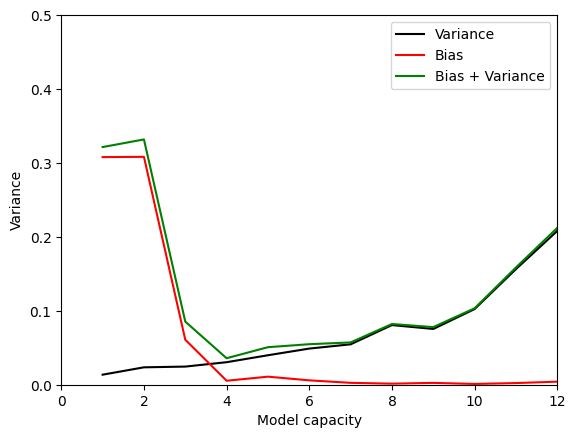

In [26]:
# Plot the noise, bias and variance as a function of capacity
hidden_variables = [1,2,3,4,5,6,7,8,9,10,11,12]
bias = np.zeros((len(hidden_variables),1)) ;
variance = np.zeros((len(hidden_variables),1)) ;

n_datasets = 100
n_data = 15
sigma_func = 0.3
n_hidden = 5

# Set random seed so that we get the same result every time
np.random.seed(1)

for c_hidden in range(len(hidden_variables)):
  # Get mean and variance of fitted model
  mean_model, std_model = get_model_mean_variance(n_data, n_datasets, hidden_variables[c_hidden], sigma_func)
  
  # Compute variance -- average of the model variance (average squared deviation of fitted models around mean fitted model)
  variance[c_hidden] = np.mean(std_model**2)
  # Compute bias (average squared deviation of mean fitted model around true function)
  bias[c_hidden] = np.mean((mean_model - y_func)**2)

# Plot the results
fig,ax = plt.subplots()
ax.plot(hidden_variables, variance, 'k-')
ax.plot(hidden_variables, bias, 'r-')
ax.plot(hidden_variables, variance+bias, 'g-')
ax.set_xlim(0,12)
ax.set_ylim(0,0.5)
ax.set_xlabel("Model capacity")
ax.set_ylabel("Variance")
ax.legend(['Variance', 'Bias', 'Bias + Variance'])
plt.show()
